In [2]:
import pandas as pd
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

In [6]:
column_name=['Patient_Family_ID','Patient_Family_Member_ID','Provider_ID','Provider_Type',
'State_Code','Date_of_Service','Medical_Procedure_Code','Dollar_Amount_of_Claim']


In [7]:
column_name=['FamilyID','FMemberID','ProviderID','Type','State','Date','MedicalType','Amount']



In [8]:
raw_data=pd.read_csv('claims_final.csv',header=None,names=column_name)

In [5]:
raw_data.describe()

,FamilyID,FMemberID,ProviderID,Type,Date,MedicalType,Amount
count,3.497743e+06,3.497743e+06,3.497743e+06,3.497743e+06,3.497743e+06,3.497743e+06,3.497743e+06
mean,2.605040e+05,1.138201e+00,9.507603e+03,1.223987e+08,2.005775e+07,3.466196e+02,7.720525e+02
std,1.513459e+05,2.495306e+00,5.114802e+03,2.007159e+02,4.279119e+03,3.019481e+02,3.947840e+02
min,1.000000e+00,0.000000e+00,1.000000e+00,1.223987e+08,2.005092e+07,1.000000e+00,1.005000e+01
25%,1.308885e+05,0.000000e+00,5.140000e+03,1.223987e+08,2.005122e+07,1.690000e+02,5.317900e+02
50%,2.515320e+05,0.000000e+00,9.152000e+03,1.223987e+08,2.006031e+07,2.820000e+02,6.666400e+02
75%,3.895130e+05,2.000000e+00,1.377300e+04,1.223987e+08,2.006062e+07,2.970000e+02,9.265600e+02
max,5.501630e+05,6.100000e+01,2.040200e+04,1.224012e+08,2.006092e+07,1.704000e+03,6.973520e+03


In [6]:
df1=raw_data[['ProviderID','State']].drop_duplicates().sort_values(['ProviderID']).reset_index(drop=True)

In [7]:
df2=pd.read_csv('medical_person.csv',header=0)
df3=pd.read_csv('avg_amount_person.csv',header=0)

In [9]:
df4=pd.merge(df2,df3,how='left',on=['personID'])

In [22]:
df4=df4.fillna(-1)
df5=df4
df5.pop('personID')

0          100000s0
1          100000s2
2          100000s3
3          100001s0
4          100004s0
5          100006s0
6          100006s1
7          100007s1
8          100007s2
9          100007s3
10         100009s0
11         100009s1
12         100009s2
13          10000s0
14          10000s1
15        100010s11
16        100010s31
17         100011s0
18         100011s1
19         100012s0
20         100012s2
21         100012s3
22         100013s0
23         100014s0
24         100014s2
25         100014s3
26         100015s0
27         100015s1
28         100017s0
29         100018s0
            ...    
543886       9997s0
543887      9997s21
543888      99980s1
543889      99980s2
543890      99980s3
543891      99982s0
543892      99982s2
543893      99982s3
543894      99985s0
543895      99987s0
543896      99988s0
543897      99989s0
543898       9998s0
543899      99990s0
543900      99990s3
543901      99990s5
543902      99992s0
543903      99993s0
543904      99994s0


In [18]:
from sklearn.preprocessing import MinMaxScaler

In [34]:

scaler = MinMaxScaler()
print(scaler.fit(df5))
# MinMaxScaler(copy=True, feature_range=(0, 1))
feature_scale=scaler.transform(df5)

MinMaxScaler(copy=True, feature_range=(0, 1))


In [38]:
feature_scale=feature_scale.reshape(543916,48)

In [42]:
from sklearn.decomposition import PCA
# TODO：通过在good_data上使用PCA，将其转换成和当前特征数一样多的维度
pca = PCA(n_components=10)
pca.fit(feature_scale)
#pca.components_
# TODO：使用上面的PCA拟合将变换施加在log_samples上
#pca_samples = pca.transform(samples)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [43]:
print(pca.explained_variance_ratio_)  


[0.3086034  0.1655957  0.13562574 0.09819653 0.082072   0.06831668
 0.05946745 0.03245224 0.02203422 0.00908061]


In [45]:
reduced_data = pca.transform(feature_scale)

In [46]:
reduced_data.shape

(543916, 10)

In [21]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
clusterer = KMeans(n_clusters=2, random_state=42)
# clusterer.fit(reduced_data)
# TODO：predict
preds = clusterer.fit_predict(reduced_data)

# TODO：get cluster center
centers = clusterer.cluster_centers_

# # TODO：predict cluster
# sample_preds = clusterer.predict(reduced_data)

# TODO：calculate（mean silhouette coefficient）
score = silhouette_score(reduced_data, preds)
score

0.4903640952879721

In [47]:
from sklearn.mixture import GaussianMixture as GMM
GM = GMM(n_components=8,covariance_type='full')
GM.fit(reduced_data)
labels=GM.predict_proba(reduced_data)

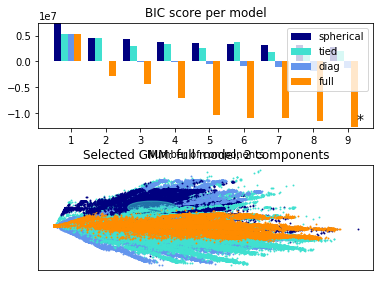

In [54]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture
X=reduced_data
bic = []
lowest_bic = np.infty
n_components_range = range(1, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)


#Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)


plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

In [57]:
GM = GMM(n_components=9,covariance_type='full')
GM.fit(reduced_data)
labels=GM.predict_proba(reduced_data)

In [58]:
labels.shape

(543916, 9)

In [147]:
cluster_score = pd.DataFrame(
    {'0_proba':labels[:,0],
    '1_proba':labels[:,1],
    '2_proba':labels[:,2],
    '3_proba':labels[:,3],
    '4_proba':labels[:,4],
    '5_proba':labels[:,5],
    '6_proba':labels[:,6],
    '7_proba':labels[:,7],
    '8_proba':labels[:,8]})

In [148]:
def order(x):
    x=x.tolist()
    return x.index(max(x))
cluster_score['cluster']=cluster_score.apply(order,axis=1)



In [149]:
score_card=dict(cluster_score['cluster'].value_counts()/543916)
score_card

{0: 0.1265783687186992,
 1: 0.2484574824053714,
 2: 0.10046220372263365,
 3: 0.12387390700034565,
 4: 0.08134528125666463,
 5: 0.08336029828135227,
 6: 0.06596790680913965,
 7: 0.06703240941615984,
 8: 0.1029221423896337}

In [150]:
from decimal import Decimal, getcontext

In [151]:
score_ev=lambda x: Decimal(x[0]*score_card[0]+x[1]*score_card[1]+x[2]*score_card[2]+x[3]*score_card[3]+x[4]*score_card[4]+x[5]*score_card[5]+x[6]*score_card[6]+x[7]*score_card[7]+x[8]*score_card[8])
cluster_score['score']=cluster_score.apply(score_ev,axis=1)

In [172]:
cluster_score['score']=cluster_score['score'].apply(lambda x: Decimal(x))

In [173]:
cluster_score.describe()

,0_proba,1_proba,2_proba,3_proba,4_proba,5_proba,6_proba,7_proba,8_proba,cluster
count,5.439160e+05,543916.000000,5.439160e+05,5.439160e+05,5.439160e+05,5.439160e+05,5.439160e+05,5.439160e+05,5.439160e+05,543916.000000
mean,1.265808e-01,0.248446,1.004798e-01,1.238732e-01,8.133284e-02,8.335854e-02,6.596982e-02,6.703239e-02,1.029266e-01,3.251598
std,3.324130e-01,0.432084,3.005050e-01,3.294245e-01,2.732994e-01,2.761979e-01,2.481221e-01,2.499842e-01,3.036546e-01,2.612332
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,6.336146e-160,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.940736e-76,1.363050e-22,0.000000e+00,6.358773e-109,1.000000
50%,0.000000e+00,0.000000,3.824485e-14,0.000000e+00,0.000000e+00,1.042541e-24,5.381239e-18,2.022979e-24,2.328366e-45,3.000000
75%,6.981156e-10,0.000000,2.312938e-11,6.320595e-13,8.836510e-08,6.168907e-20,5.569591e-13,1.751221e-16,7.613825e-18,5.000000
max,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,8.000000


In [176]:
rank1=cluster_score[['score']].reset_index()

In [177]:
person_score=pd.merge(df2.reset_index()[['index','personID']],rank1,how='left',on='index')

In [181]:
person_score['FamilyID']=person_score['personID'].apply(lambda x: x[0:x.find('s')])
person_score['FMemberID']=person_score['personID'].apply(lambda x: x[x.find('s')+1])


In [182]:
person_score[['FamilyID','FMemberID','score']].to_csv('person_score.csv',header=True, index=False)

In [183]:
person_score2=person_score[['FamilyID','FMemberID','score']]
person_score2.rename(columns={'FamilyID':'FamilyID','FMemberID':'FMemberID','score':'person_score'})

,FamilyID,FMemberID,person_score
0,100000,0,0.12387390700033573676108744621160440146923065...
1,100000,2,0.06596790680913965088105754830394289456307888...
2,100000,3,0.06596790680913965088105754830394289456307888...
3,100001,0,0.24845746150204436886177461474289884790778160...
4,100004,0,0.24845746474059013375601523421210004016757011...
5,100006,0,0.10292214238963341699228948300515185110270977...
6,100006,1,0.24845745711656577747739049755182350054383277...
7,100007,1,0.06703240941615956627330774608708452433347702...
8,100007,2,0.10046220372263366116261096294692833907902240...
9,100007,3,0.10046220372263366116261096294692833907902240...


In [184]:
person_score2['FamilyID']=person_score2.FamilyID.astype(int)
person_score2['FMemberID']=person_score2.FMemberID.astype(int)
person_score2.dtypes
#raw_data.dtypes

/Users/chenfan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/chenfan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


FamilyID      int64
FMemberID     int64
score        object
dtype: object

In [4]:
provider_score=pd.read_csv('final_pro_score.csv',header=0)

In [9]:
df100=raw_data[['ProviderID','State']].drop_duplicates().sort_values(['ProviderID']).reset_index(drop=True).reset_index()

In [10]:
df101=pd.merge(df100,provider_score,how='left',left_on='index',right_on='ProviderID')

In [44]:
person_score2=pd.read_csv('person_score.csv',header=0,dtype={'FamilyID':'int64','FMemberID':'int64','score':'object'})
person_score2.rename(columns={'FamilyID':'FamilyID','FMemberID':'FMemberID','score':'person_score'})

,FamilyID,FMemberID,person_score
0,100000,0,0.12387390700033573676108744621160440146923065...
1,100000,2,0.06596790680913965088105754830394289456307888...
2,100000,3,0.06596790680913965088105754830394289456307888...
3,100001,0,0.24845746150204436886177461474289884790778160...
4,100004,0,0.24845746474059013375601523421210004016757011...
5,100006,0,0.10292214238963341699228948300515185110270977...
6,100006,1,0.24845745711656577747739049755182350054383277...
7,100007,1,0.06703240941615956627330774608708452433347702...
8,100007,2,0.10046220372263366116261096294692833907902240...
9,100007,3,0.10046220372263366116261096294692833907902240...


In [45]:
person_score2

,FamilyID,FMemberID,score
0,100000,0,0.12387390700033573676108744621160440146923065...
1,100000,2,0.06596790680913965088105754830394289456307888...
2,100000,3,0.06596790680913965088105754830394289456307888...
3,100001,0,0.24845746150204436886177461474289884790778160...
4,100004,0,0.24845746474059013375601523421210004016757011...
5,100006,0,0.10292214238963341699228948300515185110270977...
6,100006,1,0.24845745711656577747739049755182350054383277...
7,100007,1,0.06703240941615956627330774608708452433347702...
8,100007,2,0.10046220372263366116261096294692833907902240...
9,100007,3,0.10046220372263366116261096294692833907902240...


In [46]:
raw2=pd.merge(raw_data,person_score2,how='left',on=['FamilyID','FMemberID'])

In [47]:
raw3=pd.merge(raw2,df101,how='left',left_on='ProviderID',right_on='ProviderID_x')

In [48]:
from decimal import Decimal

In [50]:
raw3['prov_score']=raw3['prov_score'].apply(lambda x: Decimal(x))

In [52]:
raw3['score']=raw3['score'].apply(lambda x: Decimal(x))

In [55]:
raw3=raw3.fillna((Decimal(0.15)))

In [56]:
raw3['score_final']=raw3['score']+raw3['prov_score']

,FamilyID,FMemberID,ProviderID,Type,State_x,Date,MedicalType,Amount,score,index,ProviderID_x,State_y,ProviderID_y,prov_score,score_final
0,518632,0,9929,122398719,NY,20060719,282,707.08,0.08336029828135227415231156555819325149059295...,4883,9929,NY,4883,0.20258594600000001673123506407137028872966766...,0.2859462442813522908835466296
1,327546,0,2299,122398719,NY,20060526,280,381.37,0.08336029828135227415231156555819325149059295...,1134,2299,NY,1134,0.20259696800000001615238431895704707130789756...,0.2859572662813522903046958845
2,342944,5,5367,122398782,NY,20060817,1688,889.29,0.24845740647989245086790788263897411525249481...,2629,5367,NY,2629,0.05160000000000000003330669073875469621270895...,0.3000574064798924509012145734
3,342944,5,5367,122398782,NY,20060717,1688,889.29,0.24845740647989245086790788263897411525249481...,2629,5367,NY,2629,0.05160000000000000003330669073875469621270895...,0.3000574064798924509012145734
4,72526,0,9029,122398719,NY,20060221,562,1681.68,0.24845747689798380886117001864477060735225677...,4445,9029,NY,4445,0.14221999900000001360034218578221043571829795...,0.3906774758979838224615122044
5,234943,1,10215,122398719,FL,20060615,288,336.63,0.06703240907375558610414856275383499450981616...,5021,10215,FL,5021,0.14219845200000000295936786187667166814208030...,0.2092308610737555890635164246
6,375277,2,3939,122398719,NY,20060413,515,1403.40,0.12387390697925497462517085978106479160487651...,1942,3939,NY,1942,0.09928995599999999865925559561219415627419948...,0.2231638629792549732844264554
7,55460,0,14582,122398719,NY,20060413,283,942.77,0.08336029828135227415231156555819325149059295...,7162,14582,NY,7162,0.02860000000000000042188474935755948536098003...,0.1119602982813522745741963149
8,534991,0,14685,122398719,CA,20060531,278,529.51,0.06703240939416997556943300651255412958562374...,7214,14685,CA,7214,0.14220142599999999188931099070032360032200813...,0.2092338353941699674587439972
9,493892,2,639,122398719,NY,20060714,288,475.65,0.06596790680913965088105754830394289456307888...,309,639,NY,309,0.20257703600000001586955988841509679332375526...,0.2685449428091396667506174367


In [59]:
raw4=raw3[['FamilyID','FMemberID','ProviderID','Type','Date','score_final']].score_final

In [79]:
raw4['score_final'].astype('float64')

0          0.285946
1          0.285957
2          0.300057
3          0.300057
4          0.390677
5          0.209231
6          0.223164
7          0.111960
8          0.209234
9          0.268545
10         0.209232
11         0.265654
12         0.303176
13         0.598057
14         0.175156
15         0.255122
16         0.209236
17         0.328235
18         0.400657
19         0.390682
20         0.598057
21         0.264158
22         0.213640
23         0.250963
24         0.329144
25         0.175474
26         0.268567
27         0.305468
28         0.242662
29         0.325998
             ...   
3502393    0.303042
3502394    0.303057
3502395    0.303057
3502396    0.326472
3502397    0.113097
3502398    0.300057
3502399    0.285929
3502400    0.245122
3502401    0.109949
3502402    0.242662
3502403    0.598057
3502404    0.095633
3502405    0.177974
3502406    0.326474
3502407    0.326418
3502408    0.218769
3502409         NaN
3502410    0.329171
3502411    0.268563


In [65]:
raw4.score_final.astype('double')

0          0.285946
1          0.285957
2          0.300057
3          0.300057
4          0.390677
5          0.209231
6          0.223164
7          0.111960
8          0.209234
9          0.268545
10         0.209232
11         0.265654
12         0.303176
13         0.598057
14         0.175156
15         0.255122
16         0.209236
17         0.328235
18         0.400657
19         0.390682
20         0.598057
21         0.264158
22         0.213640
23         0.250963
24         0.329144
25         0.175474
26         0.268567
27         0.305468
28         0.242662
29         0.325998
             ...   
3502393    0.303042
3502394    0.303057
3502395    0.303057
3502396    0.326472
3502397    0.113097
3502398    0.300057
3502399    0.285929
3502400    0.245122
3502401    0.109949
3502402    0.242662
3502403    0.598057
3502404    0.095633
3502405    0.177974
3502406    0.326474
3502407    0.326418
3502408    0.218769
3502409         NaN
3502410    0.329171
3502411    0.268563


In [68]:
raw4.to_csv('person_score_final.csv',index=False,header=False)

In [30]:
raw3.dtypes

FamilyID          int64
FMemberID         int64
ProviderID        int64
Type              int64
State_x          object
Date              int64
MedicalType       int64
Amount          float64
score           float64
index             int64
ProviderID_x      int64
State_y          object
ProviderID_y      int64
prov_score      float64
score_final     float64
dtype: object

In [29]:
for Typ in raw3['Type'].drop_duplicates().tolist():
    

122398719
122398782
122399961
122398807
122398769
122398794
122398744
122398857
122401188
122398832
122398819
122398757
122398732


In [80]:
df101

,index,ProviderID_x,State,ProviderID_y,prov_score
0,0,1,NY,0,0.349600
1,1,3,TX,1,0.349600
2,2,6,TX,2,0.349600
3,3,7,TX,3,0.349600
4,4,11,TX,4,0.349600
5,5,15,TX,5,0.349600
6,6,16,TX,6,0.349600
7,7,17,TX,7,0.349600
8,8,18,TX,8,0.349600
9,9,19,TX,9,0.349600


In [84]:
df104=pd.read_csv('Pro_rank.csv',header=None,names=['index','rank'])

In [86]:
df105=pd.merge(df104,df101[['index','ProviderID_x']],how='left',on='index')

In [88]:
df106=df105[['ProviderID_x','rank']]

In [90]:
df106.rename(columns={'ProviderID_x':"ProviderID"}).to_csv('FinalPRoblem1.csv',header=True,index=False)